# Markov chains with continous state space

Dynamics of physical systems is particularly important in robotics.
Dynamics of most physical systems are determined by differential equations.
Differential equations are used to describe other dynamically evolving systems, as well.  

These equations are usually solved with numerical methods that approximate differentials.
Usage of these approximations leads to linear update rules for the next state 

  \begin{align*}
  \boldsymbol{x}_{i+1}=A\boldsymbol{x}_i+\boldsymbol{b}+\boldsymbol{w}_i 
  \end{align*}

where $\boldsymbol{x}_{i+1}\in \mathbb{R}^\ell$ is the actual outcome, $A\boldsymbol{x}_i+\boldsymbol{b}$ is an approximation and  $\boldsymbol{w}_i$ is unknown error term and $\boldsymbol{x}_0\in \mathbb{R}^\ell$ is initail state.


A numerical approximation method is good if the average error $\mathbf{E}(\boldsymbol{w}_i)$ is near zero.
Otherwise the numerical approximation method has a systematic bias that should be removed.
Such a system can viewed as Markov chain if we additionally assume that errors $\boldsymbol{w}_i$  are independent as the current state $\boldsymbol{x}_i$ completely determines the distrinbution of the next state $\boldsymbol{x}_{i+1}$.


### Standard questions

Similarly to Markov chains with discrete statespace we can as following questions:
* How to predict the system state $\boldsymbol{x}_i$ at the $i$-th iteration if we know only the initial state $\boldsymbol{x}_0$?

* How to predict the system state $\boldsymbol{x}_i$ at the $i$-th iteration if  we know only the final state $\boldsymbol{x}_n$?

* How to predict the system state $\boldsymbol{x}_i$ at the $i$-th iteration if  we know both states $\boldsymbol{x}_0$ and $\boldsymbol{x}_n$?


These questions can be answered with belief propagation. However, the resulting formulae can quickly spiral out of the control for arbitrary error distribution. Fortunately, one can show that if all errors $\boldsymbol{w}_i$ come from multivariate normal distribution then priors, likelihoods and posteriors are also mulrivariate normal distributions and thus we can find the corresponding parameters by using moment matching and other analytical martching techniques, see the tutorial [normal_distributions_and_belief_propagation.ipynb](./tutorials/normal_distributions_and_belief_propagation.ipynb).

In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

from numpy.random import choice

from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import multivariate_normal

## I. Markov chains with a real-valued state


Let us consider a swinging pendulum and let $x_i$ be its height at the $i$-th iteration:
* We start by realeasing the pendulum at the height $x_0$.
* Then it drops and raises again $x_1$ is its highest position after which its starts to drop again.

### System dynamics

Due to the friction the pendulum looses energy. We model it through the following equation 

\begin{align*}
x_{i+1}=a x_{i} + w_i 
\end{align*}

where 
* the coeffient $a$ detrmines how fast the system looses energy 
* the error term $w_i$ captures the impact of other forces like wind. 

We model the effect other forces as follows:
* We assume that all error terms $w_i$ are independent.   
* We assume the each error term $w_i$ is distributed according $\mathcal{N}(0,\sigma_i)$.
* We assume that the initial position $x_0$ is fixed.

Then description of the system is complete. It is Markov chain.

### Simplified probablity notation

To answer the standard questions about the system state:
* What is the position of the pendulum at the $i$-th iteration if we know only the initial state $x_0$?

* What is the position of the pendulum at the $i$-th iteration if we know only the final state $x_n$?

* What is the position of the pendulum at the $i$-th iteration if we know  both states $x_0$ and $x_n$?

we need to reason about prior, likelihood and marginal posterior:
\begin{align*}
\pi[x_i]&=p[x_i|x_0]\enspace\\
\lambda[x_i]&=p[x_n|x_i]\enspace\\
p[x_i]&=p[x_i|x_0,x_n]\propto \pi[x_i]\cdot \lambda[x_i] \enspace.
\end{align*}

## II. Prior propagation

To derive the formula for the prior note that we can express $x_i$ as a linear combination of $x_0$ and independent error terms $w_1, \ldots, w_{i-1}$ and thus must have normal distribution as a linear combination of normal distributions.
Hence, we known that  

\begin{align*}
x_{i}=\mu_{i}+\varepsilon_{i},\qquad \varepsilon_i\sim\mathcal{N}(0,\rho_{i})\enspace.
\end{align*}

The following two rules allow us to compute all necessary parameters.

**Base.**
By definition of the normal distribution we can write $x_1=a x_0 + w_0$ for $w_0\sim\mathcal{N}(0, \sigma_0)$ and thus $\rho_1=\sigma_0$.

**General induction step.**
Assume that $\pi[x_{i-1}]$ is a normal distribution $\mathcal{N}(\mu_{i-1},\rho_{i-1})$ and we can express 

\begin{align*}
x_{i-1}=\mu_{i-1}+\varepsilon_{i-1}, \qquad \varepsilon_{i-1}\sim\mathcal{N}(0,\rho_{i-1})\enspace.
\end{align*}

As $x_{i}=ax_{i-1}+w_{i-1}$ we get

\begin{align*}
x_{i}=a(\mu_{i-1}+\varepsilon_{i-1})+w_{i}=a\mu_{i-1}+a\varepsilon_{i-1}+w_i
\end{align*}

and thus we can define

\begin{align*}
\mu_{i}&=a \mu_{i-1}\\
\varepsilon_{i} &= a\varepsilon_{i-1} +w_{i}\enspace
\end{align*}

to preserve the induction hypotesis. Again, $\varepsilon_i$ is a normal distribution as a linear combination of independent normal distributions and the moment matching allows us to find the corresponding variance parameter 

\begin{align*}
\rho_i^2=a^2\rho_{i-1}+\sigma_i^2\enspace.
\end{align*}

### Practical example 

Let us consider equation $x_{i+1}=0.9\cdot x_{i}+w_i$ for $w_i\sim\mathcal{N}(0, 1)$ and $x_0=10$ . Let us sample 1000 parallel runs and match theoretical prior distributions with simulated prior distributions.

In [3]:
# Number of chains
K = 1000

# Chain parameters
a = 0.9
n = 10
x_0 = 10
sigma = 1

# Chain initialisation 
X = (DataFrame(np.zeros([K, n + 1]))
     .rename(columns={i: 'x_{}'.format(i) for i in range(n+1)})
     .assign(x_0 = x_0))

# Running the chain
for i in range(n):
    X.iloc[:, i + 1] = a * X.iloc[:, i] + norm.rvs(loc=0, scale=sigma, size=K) 

mdisplay([head(X)],['states'])

# Data mainpulation for visualisation
VarNames = CategoricalDtype(['x_{}'.format(i) for i in range(n+1)], ordered = True)
df = pd.melt(X.iloc[:, 1:]).assign(variable=lambda df: df['variable'].astype(VarNames))

states 
 
 
 x_0 
 x_1 
 x_2 
 x_3 
 x_4 
 x_5 
 x_6 
 x_7 
 x_8 
 x_9 
 x_10 
 
 
 
 
 10 
 6.262693 
 4.839639 
 4.046299 
 4.160334 
 4.009399 
 2.625408 
 3.043023 
 4.274780 
 4.701948 
 2.513034 
 
 
 10 
 6.276130 
 6.865774 
 5.731518 
 5.996898 
 4.379993 
 3.764094 
 2.825653 
 0.399342 
 0.390007 
 1.639265 
 
 
 10 
 8.279821 
 8.026928 
 8.359336 
 8.424133 
 8.048292 
 6.064040 
 5.421160 
 3.938389 
 2.662904 
 2.638289 
 
 
 10 
 9.335644 
 8.969218 
 8.892292 
 8.758047 
 7.648264 
 7.612652 
 8.141381 
 7.854305 
 7.216271 
 6.565128 
 
 
 10 
 7.509192 
 7.307591 
 6.971506 
 6.135626 
 6.054733 
 5.994113 
 4.834911 
 6.314065 
 4.667654 
 4.238490

Parameters of theoretical distributions obtained with prior propagation.  

In [4]:
mu = [None] * (n + 1)
rho = [None] * (n + 1)
mu[0] = 10
rho[0] = 0


for i in range(1, n + 1):
    mu[i] = a * mu[i-1]
    rho[i] = np.sqrt(a**2 * rho[i-1]**2 + sigma**2) 

prior = DataFrame({'mu': mu, 'rho': rho}, index = X.columns)
mdisplay([prior.T], ['prior propagation'])

prior propagation 
 
 
 x_0 
 x_1 
 x_2 
 x_3 
 x_4 
 x_5 
 x_6 
 x_7 
 x_8 
 x_9 
 x_10 
 
 
 
 
 10.0 
 9.0 
 8.100000 
 7.290000 
 6.561000 
 5.904900 
 5.31441 
 4.782969 
 4.304672 
 3.874205 
 3.486784 
 
 
 0.0 
 1.0 
 1.345362 
 1.570382 
 1.731341 
 1.851488 
 1.94337 
 2.014725 
 2.070721 
 2.114991 
 2.150182

Mean values clearly match the centers of histograms.

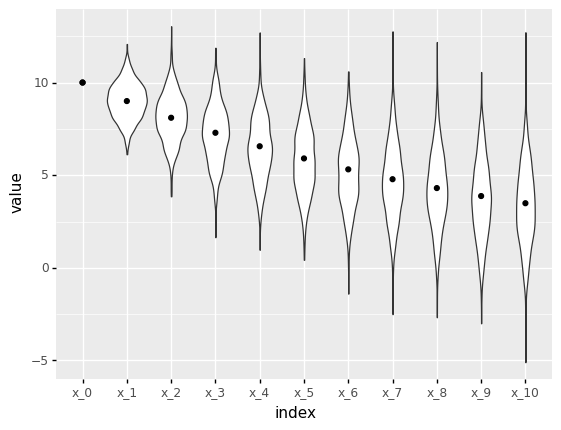

<ggplot: (688421491)>

In [5]:
pdf = (pd.melt(prior.reset_index(), id_vars=['index'])
       .assign(index = lambda df: df['index'].astype(VarNames)))

p = ggplot(df) 
p = p + geom_point(aes(x = 'index', y = 'value'), data = pdf[pdf['variable'] == 'mu'])
p = p + geom_violin(aes(x = 'variable', y = 'value'))
p = p + geom_point(aes(x = 'index', y = 'value'), data = pdf[pdf['variable'] == 'mu'])
display(p)

Standard deviations also match quite closely with the empirical ones computed from the simulation.

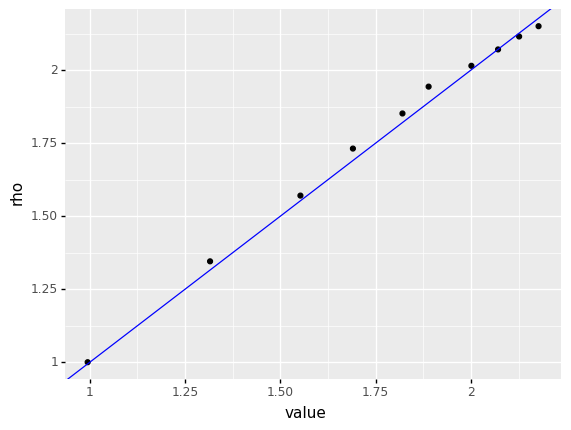

<ggplot: (688549331)>

In [6]:
p = ggplot(df.groupby('variable').std().assign(rho=rho).iloc[1:,:])
p = p + geom_point(aes(x='value', y = 'rho'))
p = p + geom_abline(aes(intercept=0, slope=1), color = 'blue')
display(p)

* Finally lets look whether the distributions are indeed normal distributions usin qq-plots. 

* By default qq-plot use a normal distribution as a theoretical match.

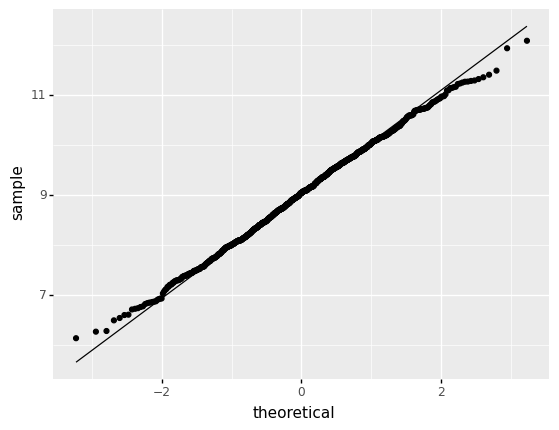

<ggplot: (688557951)>

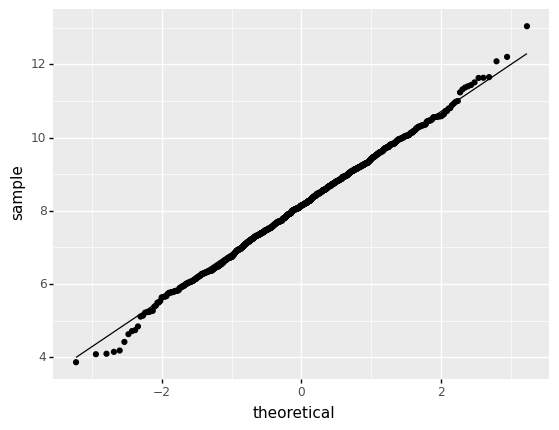

<ggplot: (688616915)>

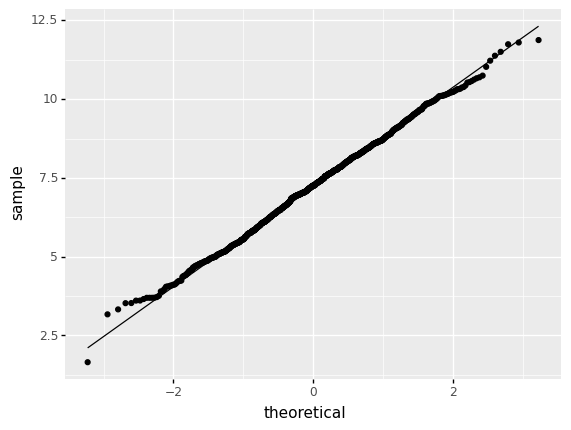

<ggplot: (688667712)>

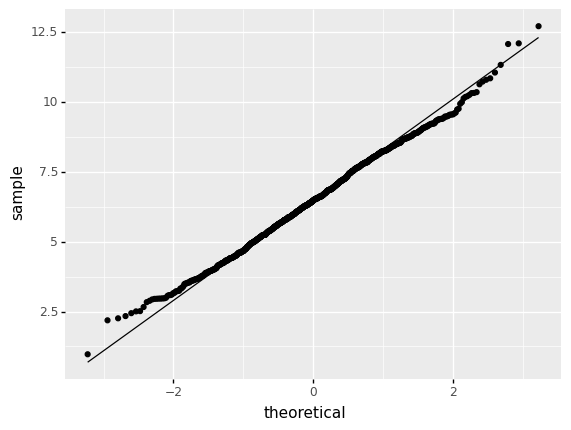

<ggplot: (688706238)>

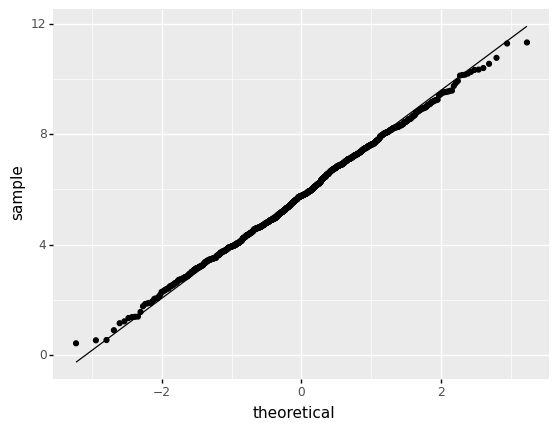

<ggplot: (688749171)>

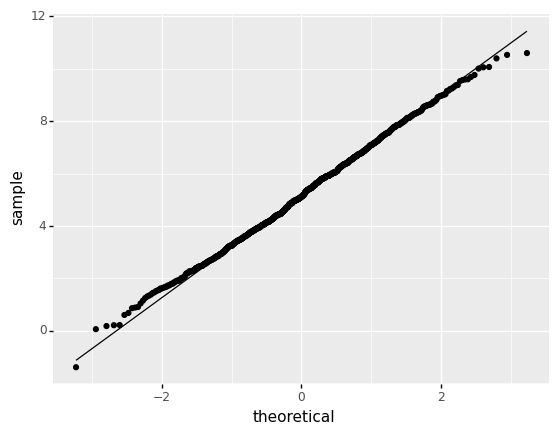

<ggplot: (688702711)>

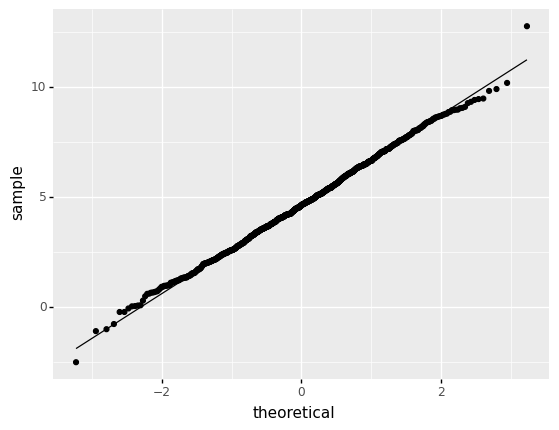

<ggplot: (688826188)>

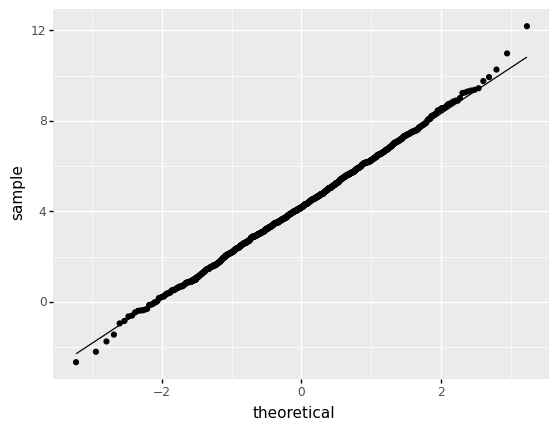

<ggplot: (688786417)>

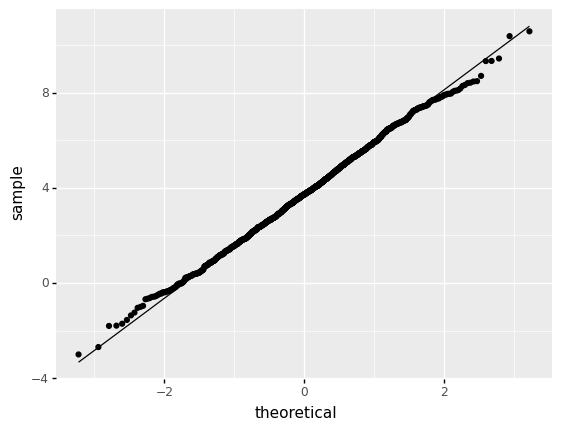

<ggplot: (688826128)>

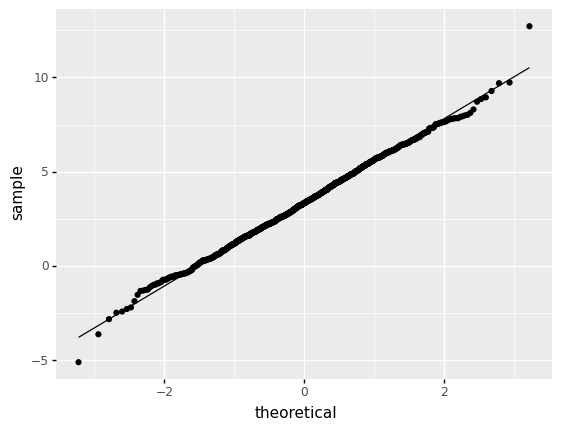

<ggplot: (688942279)>

In [7]:
for i in range(1, n+1):
    p = ggplot(df[df['variable'] == 'x_{}'.format(i)])
    p = p + geom_qq(aes(sample = 'value'))
    p = p + geom_qq_line(aes(sample = 'value'))
    display(p)


## II. Likelihood propagation

To derive the likelihood function we can express $x_n$ as a linear combination of $x_i$ and independent error terms $w_{i},\ldots, w_n$  and thus must have normal distribution as a linear combination of normal distributions.
Hence, we known that  

\begin{align*}
x_{n}=\mu_{i}^*+\varepsilon_{i},\qquad \varepsilon_i\sim\mathcal{N}(0,\delta_i)\enspace
\end{align*}

where $\mu_i^*$ and $\rho_i^*$ depend on $a$ and $x_i$. The following two rules allow us to compute all necessary parameters.

**Base.**
By definition $x_{n}=ax_{n-1}+ w_{n-1}$ for $w_{n-1}\sim\mathcal{N}(0,\sigma_{n-1})$ and thus trivially

\begin{align*}
x_{n}=\alpha_{n-1}x_{n-1}+\varepsilon_{n-1},\qquad \varepsilon_{n-1}\sim\mathcal{N}(0, \delta_{n-1})
\end{align*}

for $\alpha_{n-1}=a$ and $\delta_{n-1}=\sigma_{n-1}$.

**General induction step.**
Assume that $p[x_n|x_{i+1}]$ is a normal distribution $\mathcal{N}(\alpha_{i+1}x_{i+1},\delta_{i+1})$, i.e., we can express 

\begin{align*}
x_n= \alpha_{i+1}x_{i+1}+\varepsilon_{i+1},\qquad \varepsilon_{i+1}\sim\mathcal{N}(0, \delta_{i+1})
\end{align*}

As $x_{i+1}=ax_i+w_i$ we can express

\begin{align*}
x_n 
= \alpha_{i+1}(ax_i+w_i)+\varepsilon_{i+1}
= \alpha_{i+1} ax_i + \alpha_{i+1}w_i +\varepsilon_{i+1}
\end{align*}

and thus we can define

\begin{align*}
\alpha_{i}&=\alpha_{i+1}a\\
\varepsilon_{i} &= \alpha_{i+1}w_i +\varepsilon_{i+1}\enspace
\end{align*}

to preserve the induction hypotesis. Again $\varepsilon_i$ is a normal distribution as a linear combination of independent normal distributions and moment matching yields 

\begin{align*}
\delta_i^2=\alpha_{i+1}^2\sigma_i^2+ \delta_{i+1}^2\enspace.
\end{align*}

Therefore, we get

\begin{align*}
\lambda[x_i] = p[x_n|x_{i}]
&\propto\exp\biggl(-\frac{(x_n-\alpha_{i}x_{i})^2}{2\delta_{i}^2}\biggr)
\propto\exp\biggl(-\frac{(x_{i}-x_n/\alpha_{i})^2}{2\delta_{i}^2 /\alpha_{i}^2}\biggr)
\enspace.
\end{align*}

As the likelihood is fixed up to a constant we can choose $\lambda[x_i]$ as a densify of the normal distribution $\mathcal{N}(x_{n}/\alpha_{i}, \delta_i/\alpha_i)$.
In the following we will use notation

\begin{align*}
\mu_i^*=\frac{x_{n}}{\alpha_{i}}\\
\rho_i^*=\frac{\delta_i}{\alpha_i}
\end{align*}

### Practical example  continued

Note that we can sample conditionditional distribution $p[x_i|x_n]$ by reversing the chain. In general chain reversal is not always possible but here the additive error model makes it straightforward

\begin{align*}
x_i=\frac{x_{i+1}-w_i}{a},\qquad w_{i}\sim\mathcal{N}(0,1)
\end{align*}

Thus we can indeen simulate the conditional distribution $p[x_i|x_n]$ when $x_n$ is fixed. 


In [8]:
# Number of chains
K = 1000

# Chain parameters
a = 0.9
n = 10
x_n = 3.5
sigma = 1

# Chain initialisation 
XR = (DataFrame(np.zeros([K, n + 1]))
     .rename(columns={i: 'x_{}'.format(n-i) for i in range(n+1)}))
XR.iloc[:, 0] = x_n


# Running the chain in reverse order
for i in range(n):
    XR.iloc[:, i + 1] = (XR.iloc[:, i] - norm.rvs(loc=0, scale=sigma, size=K))/a 

mdisplay([head(XR)],['states'])

# Data mainpulation for visualisation
rdf = pd.melt(XR.iloc[:, 1:]).assign(variable=lambda df: df['variable'].astype(VarNames))

states 
 
 
 x_10 
 x_9 
 x_8 
 x_7 
 x_6 
 x_5 
 x_4 
 x_3 
 x_2 
 x_1 
 x_0 
 
 
 
 
 3.5 
 6.922877 
 8.131784 
 8.609197 
 8.695213 
 10.165117 
 9.032630 
 9.175097 
 8.575551 
 7.202579 
 5.977597 
 
 
 3.5 
 4.278687 
 5.273075 
 6.812365 
 7.891684 
 7.450701 
 8.876330 
 11.930731 
 12.925057 
 14.790246 
 15.466996 
 
 
 3.5 
 2.628783 
 5.600679 
 5.746583 
 6.330195 
 6.473583 
 7.595654 
 10.378838 
 12.661667 
 13.295280 
 14.606697 
 
 
 3.5 
 3.586649 
 3.969683 
 3.406290 
 3.596018 
 3.317949 
 2.466632 
 3.372847 
 4.170194 
 6.545816 
 6.563529 
 
 
 3.5 
 4.027560 
 4.609322 
 5.420681 
 4.838323 
 4.765336 
 6.505082 
 5.956725 
 5.393043 
 5.645329 
 5.614811

Parameters of theoretical distributions obtained with likelihood propagation.

In [9]:
alpha = [None] * n
delta = [None] * n
alpha[n - 1] = a
delta[n - 1] = sigma

for i in reversed(range(0, n - 1)):
    alpha[i] = a * alpha[i + 1]
    delta[i] = np.sqrt(alpha[i+1]**2 * sigma**2 + delta[i+1]**2)

# Lets compute alpha and delta parameters for likelihood
# and then convert them to mean and variance of rerversed chain 
likelihood = (DataFrame({'alpha': alpha, 'delta': delta}, index = X.columns[:-1])
           .assign(mu = lambda df: x_n / df['alpha'])
           .assign(rho = lambda df: df['delta'] / df['alpha']))
mdisplay([likelihood.T], ['likelihood propagation'])

likelihood propagation 
 
 
 x_0 
 x_1 
 x_2 
 x_3 
 x_4 
 x_5 
 x_6 
 x_7 
 x_8 
 x_9 
 
 
 
 
 0.348678 
 0.387420 
 0.430467 
 0.478297 
 0.531441 
 0.590490 
 0.656100 
 0.729000 
 0.810000 
 0.900000 
 
 
 2.150182 
 2.114991 
 2.070721 
 2.014725 
 1.943370 
 1.851488 
 1.731341 
 1.570382 
 1.345362 
 1.000000 
 
 
 10.037902 
 9.034112 
 8.130701 
 7.317631 
 6.585867 
 5.927281 
 5.334553 
 4.801097 
 4.320988 
 3.888889 
 
 
 6.166661 
 5.459161 
 4.810403 
 4.212289 
 3.656793 
 3.135511 
 2.638837 
 2.154159 
 1.660941 
 1.111111

Mean values clearly match the centers of histograms.

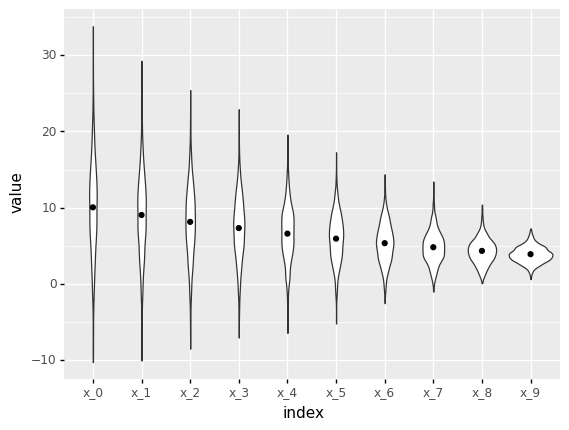

<ggplot: (688909704)>

In [10]:
pdf = (pd.melt(likelihood.reset_index(), id_vars=['index'])
       .assign(index = lambda df: df['index'].astype(VarNames)))

p = ggplot(rdf) 
p = p + geom_point(aes(x = 'index', y = 'value'), data = pdf[pdf['variable'] == 'mu'])
p = p + geom_violin(aes(x = 'variable', y = 'value'))
p = p + geom_point(aes(x = 'index', y = 'value'), data = pdf[pdf['variable'] == 'mu'])
display(p)

Standard deviations also match quite closely with the empirical ones computed from the simulation.

,value,rho
variable,,
x_0,6.259535,6.166661
x_1,5.506537,5.459161
x_2,4.881346,4.810403
x_3,4.227909,4.212289
x_4,3.679118,3.656793
x_5,3.176173,3.135511
x_6,2.649207,2.638837
x_7,2.116997,2.154159
x_8,1.655769,1.660941


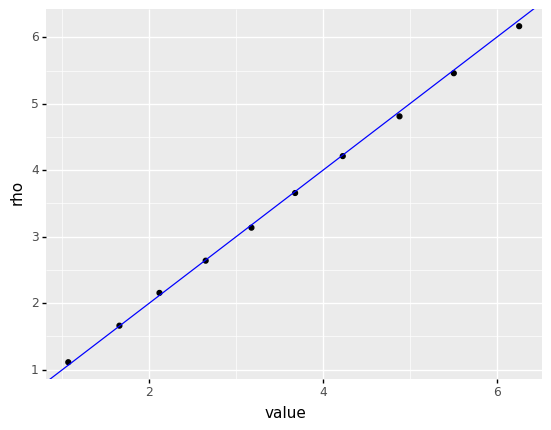

<ggplot: (688712253)>

In [11]:
rrho = pdf.loc[pdf['variable'] == 'rho', 'value'].tolist()
display(rdf.groupby('variable').std().iloc[:n].assign(rho=rrho))

p = ggplot(rdf.groupby('variable').std().iloc[:n].assign(rho=rrho))
p = p + geom_point(aes(x='value', y = 'rho'))
p = p + geom_abline(aes(intercept=0, slope=1), color = 'blue')
display(p)

As we simulated the values using a reversed Markov chain, we already know that conditional distributions preserve the normal distribution. Hence we omit qq-plots.

## III. Marginal posterior

Note that we can indeed use Bayes formula to express

\begin{align*}
p[x_i| x_0, x_n]=\frac{p[x_n|x_i, x_0]\cdot p[x_i|x_0]}{p[x_n|x_0]}
\propto p[x_i|x_0]\cdot p[x_n|x_i]\enspace.
\end{align*}

As the prior and likelihood are normal distributions, we get

\begin{align*}
p[x_i| x_0, x_n]
&\propto\exp\Biggl(-\frac{(x_i-\mu_i)^2}{2\rho_i^2}\Biggr)\cdot
\exp\biggl(-\frac{(x_{i}-\mu_i^*)^2}{2\rho_i^{*2}}\biggr)\\
&\propto\exp\Biggl(-\frac{\rho_i^{*2}(x_i-\mu_i)^2+ \rho_i^2(x_i-\mu^*_i)^2}{2\rho_i^2\rho_i^{*2}}\Biggr)\\
&\propto\exp\Biggl(-\frac{(\rho_i^{*2}+\rho_i^*)x_i^2-2(\rho_i^{*2}\mu_i+\rho_i^2\mu_i^*)x_i}{2\rho_i^2\rho_i^{*2}}\Biggr)\\
&\propto\exp\Biggl(-\frac{\rho_i^{*2}+\rho_i^*}{2\rho_i^2\rho_i^{*2}}\cdot 
\biggl(x_i^2-2\cdot\frac{\rho_i^{*2}\mu_i+\rho_i^2\mu_i^*}{\rho_i^{*2}+\rho_i^*}x_i\biggr)\Biggr)\enspace.
\end{align*}

And thus the marginal distribution $x_i|x_0,x_n$ follows indeed a normal distribution $\mathcal{N}(\mu, \sigma)$ with parameters

\begin{align*}
\mu&=\frac{\rho_i^{*2}\mu_i+\rho_i^2\mu_i^*}{\rho_i^{*2}+\rho_i^*}=
\frac{\delta_i^2\mu_i+\rho_i^2x_n\alpha_i}{\delta_i^2+\rho_i^2\alpha_i^2}\\
\sigma^2&=\frac{\rho_i^2\rho_i^{*2}}{\rho_i^{*2}+\rho_i^*}=
\frac{\alpha_i^2\rho_i^2\delta_i^2}{\delta_i^2+\rho_i^2\alpha_i^2}\enspace.
\end{align*}

Engineers are usually interested only on the maximal a posteriori estimate that is located in $\mu$ and thus they completely ignore the other equation.


### Practical example continued


We can continue with a simulation approach but we cannot sample $x_i$ directly: 
* By fixing $x_0$ and $x_n$ we can simulate the distribution of $x_i$ form both sides
* However, we must reject all sample pairs where $x_i$ values are different.  
* Both runs give the same answer with zero probability.
* No valid samples are generated during a simulation.

To resolve this problem we must sample $x_i$ in forward direction and $x_{i+1}$ in reverse direction:
* We can always glue the chains together by choosing the correct $w_i$.
* The exact value $w_i=x_{i+1}-ax_i$ determines the likelihood of such a jump.
* Thus not all $(x_i, x_{i+1})$ pairs are not equally likely.
* We have to reweight the samples according to the jump probability.


#### Theoretical estimates obtained with likelihood propagation

In [12]:
states = ['x_{}'.format(i) for i in range(1, n)]
posterior = DataFrame({'mu': [None] * (n - 1), 'sigma': [None] * (n - 1)}, index = states)

posterior['mu'] = (likelihood['rho']**2 * prior['mu'] +  prior['rho']**2 * likelihood['mu'])\
 /(prior['rho']**2 + likelihood['rho']**2)

posterior['sigma'] = np.sqrt(prior['rho']**2 * likelihood['rho']**2 
                             /(prior['rho']**2 + likelihood['rho']**2))

display(posterior.T)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
mu,9.001107,8.102227,7.293372,6.565554,5.910686,5.321493,4.791428,4.314600,3.885713
sigma,0.983634,1.295644,1.471451,1.564815,1.594288,1.564815,1.471451,1.295644,0.983634


#### Pair formation and weighting

We reuse forward and reverse samples, as we are never consider the posterior of two states simultaneusly.  

In [13]:
pairs = pd.concat([DataFrame({
    'state': 'x_{}'.format(i), 
    'xi_1': X['x_{}'.format(i)], 
    'xi_2': XR['x_{}'.format(i+1)]}) for i in range(1, n)], axis=0).reset_index(drop=True)

In [14]:
pairs = (pairs
         .assign(w_i = lambda df: df['xi_2'] - a *  df['xi_1'])
         .assign(pr = lambda df: norm.pdf(df['w_i'], loc=0, scale=sigma)))


head(pairs)

,state,xi_1,xi_2,w_i,pr
0,x_1,6.262693,8.575551,2.939127,5.309957e-03
1,x_1,6.276130,12.925057,7.276540,1.268794e-12
2,x_1,8.279821,12.661667,5.209828,5.093688e-07
3,x_1,9.335644,4.170194,-4.231885,5.152902e-05
4,x_1,7.509192,5.393043,-1.365230,1.571013e-01


#### Direct sampling according to the weights 

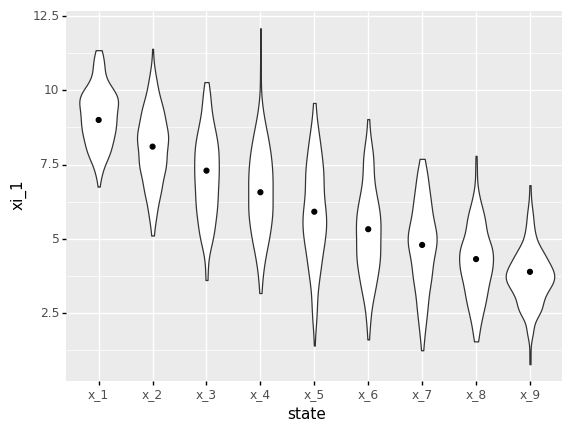

<ggplot: (688529851)>

In [15]:
def resample(df, p, size):
    return df.sample(n=size, weights=p/sum(p), replace=True)

samples = pairs.groupby('state').apply(lambda df: resample(df, df['pr'], int(K/5)))
head(samples)

p = ggplot(samples) 
p = p + geom_violin(aes(x = 'state', y = 'xi_1'))
p = p + geom_point(aes(x = 'index', y = 'mu'), data = posterior.reset_index()) 
display(p)

Note that violin plots for state samples are bumpy. This is caused by the fact that there are only few observations with high probability -- we have a large bump on the left side. 


/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


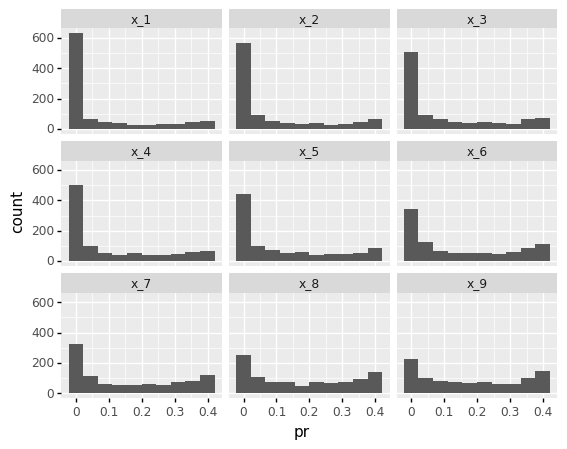

<ggplot: (689065045)>

In [16]:
p = ggplot(pairs)
p = p + geom_histogram(aes(x = 'pr'), bins=10) 
p = p + facet_wrap('state', ncol=3) 
display(p)

Corresponding parameter estimates using sample reweighting instead of resampling.

In [17]:
def weighted_mean(x, p):
    return np.average(x, weights = p/sum(p))


def weighted_std(x, p):
    return np.sqrt(np.cov(x, aweights=p/sum(p)))

In [18]:
posterior['smean'] = pairs.groupby('state').apply(lambda df: weighted_mean(df['xi_1'], df['pr']))
posterior['sstd']  = pairs.groupby('state').apply(lambda df: weighted_std(df['xi_1'], df['pr']))

display(posterior.T)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
mu,9.001107,8.102227,7.293372,6.565554,5.910686,5.321493,4.791428,4.314600,3.885713
sigma,0.983634,1.295644,1.471451,1.564815,1.594288,1.564815,1.471451,1.295644,0.983634
smean,8.999568,8.099980,7.209568,6.556286,5.823803,5.255684,4.670919,4.227948,3.839146
sstd,0.972645,1.322118,1.525884,1.610220,1.659266,1.547349,1.457262,1.253050,0.987726


#### Comparison of theoretical and sampled parameters

Mean values match rather nicely. Variance fit for the variance parameter is worse but this is also a second order moment that converges more slowly.  

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


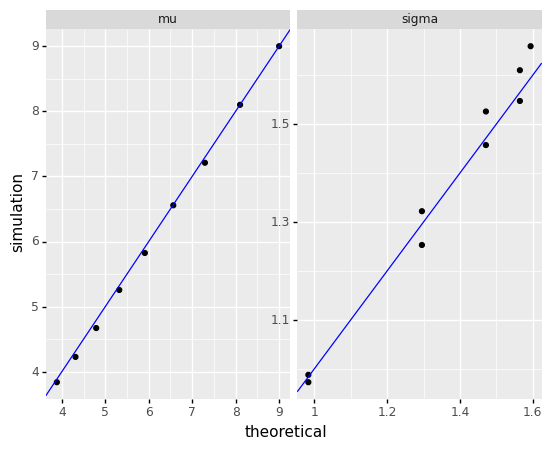

<ggplot: (689507895)>

In [19]:
pdf = pd.concat([(posterior[['mu', 'smean']]
                  .rename(columns={'mu':'theoretical','smean': 'simulation'})
                  .assign(parameter = 'mu')),
                 (posterior[['sigma', 'sstd']]
                  .rename(columns={'sigma':'theoretical','sstd': 'simulation'})
                  .assign(parameter = 'sigma'))])

p = ggplot(pdf) 
p = p + geom_point(aes(x = 'theoretical', y = 'simulation'))
p = p + geom_abline(aes(intercept=0, slope=1), color = 'blue')
p = p + facet_wrap('parameter', scales = 'free')
p

# Home exercises

## 5.1 Imputation with a Markov chain (<font color='red'>1p</font>)

Consider a Markov chain with equation $x_{i+1}=1.3\cdot x_i+w_i$ for $w_i\sim\mathcal{N}(0,1)$. Construct an imputation algorithm that fills out missing $x_i$ values with the most probable outcome and provides also $90\%$ credibility intervals around it.
Apply it for the observations $x_1=128.1, x_5=364.1, x_6=473.4, x_8=800.3, x_{10}=1352.1$.

## 5.2  General belief propagation formulae (<font color="red">3p</font>)

Derive belief propagation formulae for a Markov chain with multivariate state space

\begin{align*}
\boldsymbol{x}_{i+1}= A\boldsymbol{x}_i+\boldsymbol{w}_i,\qquad \boldsymbol{w}_i\sim\mathcal{N}(\boldsymbol{0}, Q_i) \enspace.
\end{align*}

where the noise can be colored, i.e., $Q_i$ does not have to be a diagonal matrix.
As for the univariate case, we can easily see that priors and likelihoods must be multivariate normal distributions. Let us use the following parametrisation

\begin{align*}
 p[x_i|x_0]&\sim\mathcal{N}(\boldsymbol{\mu}_i,\Sigma_i)\\
 p[x_n|x_i]&\sim\mathcal{N}(\boldsymbol{\mu}_i^*,\Sigma_i^*)\\
 p[x_i|x_0,x_n]&\sim\mathcal{N}(\boldsymbol{\mu}_i^*,\Sigma_i^\circledast)\enspace.
\end{align*}

Also, you can assume that $A$ is invertible matrix when you derive likelihood parameters. 


## 5.3 Linear approximation (<font color="red">5p</font>)

Consider a non-linear system $x_{i+1}=3.5699\cdot x_i(1-x_i)$ with a starting point $x_0=0.5$. Compute a reasonably long sequence of observation $x_0,x_1,\ldots,x_n$.
Train a linear model $x_{i+1}=a_0+a_{1}x_i+a_2x_{i-1}\cdots+a_{\ell}x_{i-\ell}$ that locally predicts function with a reasonable accuracy.  Convert this function into a  Markov chain with a multivariate state 

\begin{align*}
\boldsymbol{x}=(1, x_i, x_{i-1}, \ldots, x_{i-\ell})
\end{align*}

and estimate the mean and covariance of the error $\boldsymbol{w}_{i}=\boldsymbol{x}_{i+1}-A\boldsymbol{x}_i$. Is the error white or coloured, i.e., is the covariance matrix diagonal or not? 
Show that you can use general belief propagation formulas to impute missing observations if you know $x_1, x_5, x_6, x_8, x_{10}$. As in the first exercise give the most probale estimates and credibility intervals. Visualise these predictions with a plot and add  the actual values for the reference.